# Preprocess

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
# data = pd.read_csv('../raw_data/100k_data.csv')

In [4]:
data_path = '../raw_data/SEND_150k_data.csv'
data = pd.read_csv(data_path)
# data = data.dropna()
df = data.dropna().sample(30000,random_state=0)

In [5]:
df[['title']].head(20)

,title
72359,This is Picard. His gotcha day was February 11...
117238,Hound Nap
74310,When is breakfast?!
110206,Finally figured out where the socks disappear ...
49964,Walter Post-Surgery with his dinosaur
105794,First look for my lovely john
40869,They Say Sleeping Is Good For You!
92190,Just chillin after a long day
57167,Hail to the king baby 👑
109746,Our Akitan Family everyday - day 1


In [6]:
def count_len(text):
    text = text.split(' ')
    length = len(text)
    return length

In [7]:
df['title_len']=df['title'].apply(count_len)

In [8]:
data['title_len']=data['title'].apply(count_len)

In [9]:
df['title_len'].mean()

8.573566666666666

In [10]:
data['title_len'].mean()

8.588895179660035

## Packages

In [11]:
!pip install emot # package to process emoji

In [12]:
import re
import pickle
import string
from emot.emo_unicode import UNICODE_EMOJI
import nltk
import emoji

### Demojize

In [11]:
# function demojize(self, text):
#    emoji.demojize(text)

# function word2vec(self, text):
#    new_text = self.demojize(text)
#    my_vect = Word2Vec(new_test)
#    return my_vect

In [12]:
def demojize(text):
    clean_text = emoji.demojize(text)
    clean_text = clean_text.replace(':', '')
    clean_text = clean_text.replace('_', ' ')
    return clean_text

In [108]:
# demojize('Python is 👍')

In [109]:
# df['title'] = df.title.apply(demojize)

## CLEANING

### For the Base Model, I decide to not consider the impact of special Punctuation like '?' and '!'
(strip + lowercase + numbers + punctuation/symbols)

##### Contraction Map

In [10]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

##### code

In [13]:
# expand_contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

NameError: name 'CONTRACTION_MAP' is not defined

In [ ]:
df['basic_cleaning'] = df.title.apply(expand_contractions)

In [15]:
my_punc = string.punctuation
my_punc += '—'
my_punc += '“”’'

In [18]:
def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())
    for punctuation in my_punc:
        sentence = sentence.replace(punctuation, '')
    sentence = sentence.strip()
    return sentence

In [19]:
df['basic_cleaning'] = df.basic_cleaning.apply(basic_cleaning)

AttributeError: 'DataFrame' object has no attribute 'basic_cleaning'

### Convert Emoji to Words

In [14]:
UNICODE_EMOJI

{'🥇': ':1st_place_medal:',
 '🥈': ':2nd_place_medal:',
 '🥉': ':3rd_place_medal:',
 '🆎': ':AB_button_(blood_type):',
 '🏧': ':ATM_sign:',
 '🅰': ':A_button_(blood_type):',
 '🇦🇫': ':Afghanistan:',
 '🇦🇱': ':Albania:',
 '🇩🇿': ':Algeria:',
 '🇦🇸': ':American_Samoa:',
 '🇦🇩': ':Andorra:',
 '🇦🇴': ':Angola:',
 '🇦🇮': ':Anguilla:',
 '🇦🇶': ':Antarctica:',
 '🇦🇬': ':Antigua_&_Barbuda:',
 '♒': ':Aquarius:',
 '🇦🇷': ':Argentina:',
 '♈': ':Aries:',
 '🇦🇲': ':Armenia:',
 '🇦🇼': ':Aruba:',
 '🇦🇨': ':Ascension_Island:',
 '🇦🇺': ':Australia:',
 '🇦🇹': ':Austria:',
 '🇦🇿': ':Azerbaijan:',
 '🔙': ':BACK_arrow:',
 '🅱': ':B_button_(blood_type):',
 '🇧🇸': ':Bahamas:',
 '🇧🇭': ':Bahrain:',
 '🇧🇩': ':Bangladesh:',
 '🇧🇧': ':Barbados:',
 '🇧🇾': ':Belarus:',
 '🇧🇪': ':Belgium:',
 '🇧🇿': ':Belize:',
 '🇧🇯': ':Benin:',
 '🇧🇲': ':Bermuda:',
 '🇧🇹': ':Bhutan:',
 '🇧🇴': ':Bolivia:',
 '🇧🇦': ':Bosnia_&_Herzegovina:',
 '🇧🇼': ':Botswana:',
 '🇧🇻': ':Bouvet_Island:',
 '🇧🇷': ':Brazil:',
 '🇮🇴': ':British_Indian_Ocean_Territory:',
 '🇻🇬': ':British_Vir

In [168]:
# def convert_emojis(text):
#     for emot in UNICODE_EMOJI:
#         text = re.sub(r'('+emot+')', "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()), text)
#     return text

### Remove Stopwords

In [16]:
from nltk.corpus import stopwords

In [17]:
STOPWORDS = set(stopwords.words('english'))

In [18]:
'me' in STOPWORDS

True

In [19]:
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [30]:
df['no_stopword']=df['basic_cleaning']

In [31]:
df['no_stopword'] = df['no_stopword'].apply(remove_stopwords)

In [22]:
remove_stopwords('can someone tell me how she')

'someone tell'

In [176]:
# how to deal with # (tags); how to deal with 2 emojis # how to deal with !&?; Chat Words Conversion e.g. wtf/lmk

In [32]:
df['no_stopword']

72359     picard gotcha day february th kept sane throug...
117238                                            hound nap
74310                                             breakfast
110206                      finally figured socks disappear
49964                           walter postsurgery dinosaur
                                ...                        
32080                                                  cool
6865                                          little piglet
121554                                 border collie forest
43425                     difference winter summer coat dog
133671    big red practicing selfcontrol would ever gues...
Name: no_stopword, Length: 30000, dtype: object

### Tokenize

In [26]:
from nltk.tokenize import word_tokenize

In [33]:
df['no_stopword'] = df.no_stopword.apply(word_tokenize)

In [246]:
df['no_stopword'].head(30)

72359     [picard, gotcha, day, february, th, kept, sane...
117238                                         [hound, nap]
74310                                           [breakfast]
110206                 [finally, figured, socks, disappear]
49964                       [walter, postsurgery, dinosaur]
105794                          [first, look, lovely, john]
40869                                 [say, sleeping, good]
92190                                  [chillin, long, day]
57167                                 [hail, king, baby, 👑]
109746                      [akitan, family, everyday, day]
54282            [good, boy, ringing, new, year, dogquilla]
49350            [strolling, turin, saw, adorable, puppies]
4870               [eating, dirt, majestic, three, seconds]
80003     [lost, maki, yesterday, blood, cancer, know, e...
132276                                        [dog, cooler]
70254              [parents, last, borzoi, first, labrador]
129993               [today, found, long

### Lemmatize

In [34]:
from nltk.stem import WordNetLemmatizer

def lemma(text):
    lemmatizer = WordNetLemmatizer() # Instantiate lemmatizer
    lemmatized_n = [lemmatizer.lemmatize(word,pos='n') for word in text]
#     print(lemmatized_n)
    lemmatized_v = [lemmatizer.lemmatize(word,pos='v') for word in lemmatized_n] 
#     print(lemmatized_v)
#     cleaned_sentence = ' '.join(word for word in lemmatized_v)
#     return cleaned_sentence
    return lemmatized_v

In [35]:
df['lemmatize'] = df['no_stopword']

In [36]:
df['lemmatize'] = df['lemmatize'].apply(lemma)

In [37]:
df['lemmatize'].head(20)

72359     [picard, gotcha, day, february, th, keep, sane...
117238                                         [hound, nap]
74310                                           [breakfast]
110206                   [finally, figure, sock, disappear]
49964                       [walter, postsurgery, dinosaur]
105794                          [first, look, lovely, john]
40869                                    [say, sleep, good]
92190                                  [chillin, long, day]
57167                                 [hail, king, baby, 👑]
109746                      [akitan, family, everyday, day]
54282               [good, boy, ring, new, year, dogquilla]
49350                 [stroll, turin, saw, adorable, puppy]
4870                   [eat, dirt, majestic, three, second]
80003     [lose, maki, yesterday, blood, cancer, know, e...
132276                                        [dog, cooler]
70254               [parent, last, borzoi, first, labrador]
129993                [today, find, long

Count the length of each title (Need to split all the words and emoji beforehand)

In [38]:
X_lemma = df['lemmatize']

In [186]:
# cannot deal with abbreviation; doin; cannot seperate emoji

### Tokenizer **Don't NEED NOW

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(df.lemmatize)
df['tokenized']=tk.texts_to_sequences(df.lemmatize)

KeyboardInterrupt: 

In [137]:
df.head(30)

,Unnamed: 0,id,time_stamp,title,Image_url,upvote_ratio,upvotes,no_stopword,lemmatize,tokenized
26379,26379,nu260w,1.623034e+09,patriot poms macieall black pom pinning her b...,https://i.redd.it/41g91fvzbr371.png,1.00,5,"[patriot, poms, macieall, black, pom, pinning,...","[patriot, pom, macieall, black, pom, pin, baby...","[3413, 902, 3414, 247, 902, 3415, 27, 9, 1129,..."
46598,46598,g3c9su,1.587163e+09,flora our golden retriever,https://i.redd.it/mj6cwtm1igt41.jpg,0.91,28,"[flora, golden, retriever]","[flora, golden, retriever]","[3416, 166, 356]"
58211,58211,cwg55z,1.566968e+09,does anybody know what kind of dog this is we ...,https://i.redd.it/b0zcwy7of4j31.jpg,0.95,15,"[anybody, know, kind, dog, found, stray, exact...","[anybody, know, kind, dog, find, stray, exactl...","[686, 44, 344, 1, 57, 497, 809, 147, 50, 1, 49..."
13796,13796,sr2itc,1.644704e+09,my american bulldog puppy,https://i.redd.it/7w5hzqvn6hh81.jpg,1.00,1,"[american, bulldog, puppy]","[american, bulldog, puppy]","[470, 296, 14]"
17481,17481,r7izrl,1.638484e+09,mac chewer of the stick love life by the river,https://www.reddit.com/gallery/r7izrl,0.91,15,"[mac, chewer, stick, love, life, river]","[mac, chewer, stick, love, life, river]","[1512, 3417, 122, 3, 43, 563]"
23443,23443,oy6wi5,1.628126e+09,my baby boy gunner a new father,https://i.redd.it/8l48os1lwff71.jpg,0.94,13,"[baby, boy, gunner, new, father]","[baby, boy, gunner, new, father]","[27, 4, 1012, 15, 1130]"
23954,23954,orlr1p,1.627253e+09,good girl had a stroke she lived dog years ho...,https://i.redd.it/9dsiq2udsfd71.jpg,1.00,1,"[good, girl, stroke, lived, dog, years, hope, ...","[good, girl, stroke, live, dog, year, hope, sh...","[10, 9, 1847, 192, 1, 6, 195, 24, 205, 597, 286]"
42796,42796,hjtt2d,1.593681e+09,success,https://i.redd.it/0150bbtove851.jpg,0.95,108,[success],[success],[1513]
15633,15633,ryus2n,1.641629e+09,lost my baby girl a year ago today she got ran...,https://i.redd.it/bjv509ij7fa81.jpg,0.94,15,"[lost, baby, girl, year, ago, today, got, ran,...","[lose, baby, girl, year, ago, today, get, run,...","[162, 27, 9, 6, 73, 17, 2, 151, 21, 7, 185, 7,..."
14393,14393,sifa5d,1.643776e+09,my dod in a christmas sweater 🥺🥺🥺🥺 do u like it,https://www.reddit.com/gallery/sifa5d,1.00,1,"[dod, christmas, sweater, 🥺🥺🥺🥺, u, like]","[dod, christmas, sweater, 🥺🥺🥺🥺, u, like]","[3418, 87, 1013, 3419, 80, 11]"


In [170]:
tk.word_index

{'dog': 1,
 'get': 2,
 'boy': 3,
 'love': 4,
 'old': 5,
 'year': 6,
 'day': 7,
 'delete': 8,
 'user': 9,
 'happy': 10,
 'good': 11,
 'girl': 12,
 'little': 13,
 'like': 14,
 'best': 15,
 'look': 16,
 'today': 17,
 'puppy': 18,
 'new': 19,
 'friend': 20,
 'meet': 21,
 'take': 22,
 'time': 23,
 'shes': 24,
 'he': 25,
 'one': 26,
 'month': 27,
 'pup': 28,
 'go': 29,
 'first': 30,
 'picture': 31,
 'think': 32,
 'say': 33,
 'im': 34,
 'baby': 35,
 'want': 36,
 'week': 37,
 'enjoy': 38,
 'doggo': 39,
 'sleep': 40,
 'sweet': 41,
 'make': 42,
 'cute': 43,
 'walk': 44,
 'name': 45,
 'breed': 46,
 'home': 47,
 'mix': 48,
 'life': 49,
 'know': 50,
 'smile': 51,
 'miss': 52,
 'ago': 53,
 'play': 54,
 'ever': 55,
 'rescue': 56,
 'face': 57,
 'see': 58,
 'big': 59,
 '❤️': 60,
 'always': 61,
 'beautiful': 62,
 'guy': 63,
 'still': 64,
 'help': 65,
 'two': 66,
 'find': 67,
 'dont': 68,
 'much': 69,
 'morning': 70,
 'eye': 71,
 'snow': 72,
 'work': 73,
 'birthday': 74,
 'buddy': 75,
 'sit': 76,
 'bed':

### Preprocess Whole Data

In [40]:
data['basic_cleaning'] = data.title.apply(expand_contractions)

data['basic_cleaning'] = data.basic_cleaning.apply(basic_cleaning)

data['no_stopword'] = data['basic_cleaning'].apply(remove_stopwords)

data['no_stopword'] = data.no_stopword.apply(word_tokenize)

data['lemmatize'] = data['no_stopword'].apply(lemma)

In [41]:
data['lemmatize']

0                                      [cute, little, baby]
1         [myboytonka, bluestaffy, familypet, enjoy, wal...
2         [bennington, say, he, basset, pitt, catahoula,...
3         [dog, pretty, much, color, whats, leave, morni...
4                        [happy, malinois, name, han, solo]
                                ...                        
151893                       [unbearable, cuteness, stella]
151894                       [lexi, day, bring, home, spca]
151895                                  [something, stella]
151896                                 [dog, wear, doggles]
151897                                              [sadie]
Name: lemmatize, Length: 151898, dtype: object

### Word2Vector (Alternative to tokenize)

#### Pre-trained model glove-twitter-25

In [78]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
glove_vectors = gensim.downloader.load('glove-twitter-25')
glove_vectors.most_similar('twitter')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


KeyboardInterrupt: 

#### My model of whole dataset

In [233]:
from gensim.models import Word2Vec
vec_size = 20
word2vec = Word2Vec(sentences=data['lemmatize'], vector_size=vec_size, min_count=10, window=4)
# how to select vector_size? might be too big

In [234]:
word2vec # trained base on whole dataset

In [235]:
word2vec.wv['dog']

array([ 1.3517152 , -1.9031105 ,  0.39014116,  0.4409856 , -1.2348068 ,
       -1.8261825 , -0.50980526,  0.9770071 ,  1.3244848 , -1.2770796 ,
        0.35140288,  0.46993938, -0.05866685, -1.103844  , -0.7304762 ,
        0.0809565 ,  0.12632218, -1.1952039 , -1.0516698 , -0.28064433],
      dtype=float32)

In [237]:
word2vec.wv.most_similar('dog', topn=15)

[('animal', 0.7748593688011169),
 ('pup', 0.7626678347587585),
 ('doggo', 0.7018442153930664),
 ('doggy', 0.6958211660385132),
 ('also', 0.6898082494735718),
 ('place', 0.684063732624054),
 ('kid', 0.6815078258514404),
 ('doggos', 0.6798000931739807),
 ('puppers', 0.6708903312683105),
 ('person', 0.6566869616508484),
 ('probably', 0.6530404090881348),
 ('own', 0.6477996110916138),
 ('theyre', 0.6432768702507019),
 ('puppy', 0.6416468620300293),
 ('one', 0.6403688192367554)]

#### Pre-trained model 'glove-twitter-200'

In [41]:
import gensim.downloader as api
from gensim.models import Word2Vec

In [51]:
twitter200_corpus = api.load('glove-twitter-200')
twitter200_corpus.most_similar('twitter')

KeyboardInterrupt: 

In [76]:
twitter200_corpus.similarity('tree', 'leaf')

NameError: name 'twitter200_corpus' is not defined

In [234]:
twitter200_corpus.most_similar('dog', topn=10)

[('dogs', 0.8483485579490662),
 ('cat', 0.832430362701416),
 ('puppy', 0.7890411019325256),
 ('pet', 0.7524258494377136),
 ('cats', 0.7141677141189575),
 ('horse', 0.6632055640220642),
 ('animal', 0.657815158367157),
 ('kitten', 0.6441184878349304),
 ('little', 0.632893979549408),
 ('kid', 0.6253357529640198)]

### Embedding

In [238]:
import numpy as np
example = ['this', 'movie', 'is', 'the', 'worst', 'action', 'movie', 'ever']
example_missing_words = ['this', 'movie', 'is', 'laaaaaaaaaame']
def embed_sentence(word2vec, sentence):
    wv = word2vec.wv
    to_array = []
#     print(sentence)
    for word in sentence:
        if word in wv.key_to_index:
            to_array.append(wv[word])
    return np.array(to_array)

In [239]:
df['embedding'] = df['lemmatize'].apply(lambda x: embed_sentence(word2vec,x))

In [48]:
df[['embedding']]

,embedding
72359,"[[0.8587935, -0.5100097, -0.6470577, -0.542312..."
117238,"[[-0.8953133, -0.9158622, -0.63884795, -0.1204..."
74310,"[[0.16461626, 0.32013926, 0.009713764, 0.18614..."
110206,"[[0.4197325, 1.005667, 0.22347336, -1.0603021,..."
49964,"[[-0.017749067, -0.13825125, -0.15346892, 0.29..."
...,...
32080,"[[-0.90217334, -0.38298208, -0.031965636, -0.0..."
6865,"[[-0.08284962, 0.005258159, 0.34169534, 0.3595..."
121554,"[[-1.8096888, -1.441027, -1.5824249, 0.1120013..."
43425,"[[-0.14885898, 0.051192172, -0.24123818, -0.00..."


### Padding

In [283]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 15
X_train = pad_sequences(df['embedding'], dtype='float32', padding='post', value=-1000,maxlen=max_length)
# padding with [0., 0., 0., .......]

In [241]:
X_train.shape

(20000, 15, 20)

### Combine Model for py. file

In [149]:
import numpy as np
import pandas as pd

import re
import pickle
import string
import nltk

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [150]:
my_punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’'

In [89]:
def preprocessing(text,word2vec=word2vec,contraction_mapping=CONTRACTION_MAP):
    
    # 1. Expand Contractions
    """Expand the contractions in English. e.g. I'm ==> I am"""
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    
    # 2. Basic Cleaning
    sentence = expanded_text.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())
    for punctuation in my_punc:
        sentence = sentence.replace(punctuation, '')
    sentence = sentence.strip()
    
    # 2. Remove Stopwords
    STOPWORDS = set(stopwords.words('english'))
    remove_s = " ".join([word for word in str(sentence).split() if word not in STOPWORDS])
    
    # 3. Word Tokenize
    word_tokens = word_tokenize(remove_s)
    
    # 4. Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_n = [lemmatizer.lemmatize(word,pos='n') for word in word_tokens]
    lemmatized_v = [lemmatizer.lemmatize(word,pos='v') for word in lemmatized_n] 
    
    # 5. Embedding
    wv = word2vec.wv
    to_array = []    
    for word in lemmatized_v:
        if word in wv.key_to_index:
            to_array.append(wv[word])
    return np.array(to_array)

In [160]:
X_embedding = df['title'].apply(lambda sentence: preprocessing(sentence,word2vec))

In [161]:
X_train = pad_sequences(X_embedding, dtype='float32', padding='post', maxlen=max_length)

# Build a model

#### Setting the Binary Y

In [52]:
def binary_cat_upvotes(original_df, threshold=50):
    """
    Takes column from df called 'upvotes' and returns df with new column
    'cat_upvotes' which is 1 if upvotes is above threshold, and 0 otherwise.
    """
    dataframe = original_df.copy()
    if 'upvotes' not in original_df.columns:
        raise ValueError("df has no column named 'upvotes'")
    def trans(number):
        if number >= threshold:
            return 1
        else:
            return 0
    dataframe['cat_upvotes'] = dataframe['upvotes'].apply(trans)
    return dataframe

In [243]:
df = data.dropna().sample(20000,random_state=0)

In [330]:
df = binary_cat_upvotes(df, 30)

In [331]:
df['basic_cleaning'] = df.title.apply(basic_cleaning)

df['no_stopword'] = df['basic_cleaning'].apply(remove_stopwords)

df['no_stopword'] = df.no_stopword.apply(word_tokenize)

df['lemmatize'] = df['no_stopword'].apply(lemma)

df['embedding'] = df['lemmatize'].apply(lambda x: embed_sentence(word2vec,x))

# df['padding'] = pad_sequences(df['embedding'], dtype='float32', padding='post', maxlen=max_length)

In [332]:
X = pad_sequences(df['embedding'], dtype='float32', padding='post', maxlen=max_length,value=-1000)

In [333]:
y = df['cat_upvotes']

In [334]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [286]:
df[df.cat_upvotes==0].describe()

,Unnamed: 0,time_stamp,upvote_ratio,upvotes,title_len,cat_upvotes
count,17997.000000,1.799700e+04,17997.00000,17997.000000,17997.000000,17997.0
mean,76783.757571,1.583589e+09,0.93701,16.551814,8.304551,0.0
std,43663.055107,5.138741e+07,0.08889,20.781138,7.591897,0.0
min,0.000000,1.271672e+09,0.11000,0.000000,1.000000,0.0
25%,38860.000000,1.543619e+09,0.90000,1.000000,3.000000,0.0
50%,77718.000000,1.584039e+09,0.97000,9.000000,6.000000,0.0
75%,114456.000000,1.627469e+09,1.00000,21.000000,10.000000,0.0
max,151895.000000,1.668689e+09,1.00000,109.000000,67.000000,0.0


In [ ]:
0-1, 2-30, 

In [353]:
data.upvotes.quantile([0.1,0.2,0.25,0.5,0.6,0.75,0.8])

0.10     1.0
0.20     1.0
0.25     2.0
0.50    11.0
0.60    16.0
0.75    30.0
0.85    62.0
Name: upvotes, dtype: float64

#### Baseline Model

In [77]:
df.describe()

,Unnamed: 0,time_stamp,upvote_ratio,upvotes,title_len,cat_upvotes
count,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000
mean,76091.404650,1.584404e+09,0.942166,94.114200,8.557500,0.426550
std,43807.699893,5.138389e+07,0.085852,553.474625,7.824197,0.494588
min,0.000000,1.271672e+09,0.110000,0.000000,1.000000,0.000000
25%,37964.750000,1.544237e+09,0.910000,2.000000,4.000000,0.000000
50%,76717.000000,1.585114e+09,0.980000,11.000000,6.000000,0.000000
75%,114019.500000,1.628408e+09,1.000000,30.000000,11.000000,1.000000
max,151895.000000,1.668689e+09,1.000000,34572.000000,67.000000,1.000000


In [79]:
accuracy = 1 - 0.426550
accuracy

0.57345

<AxesSubplot:>

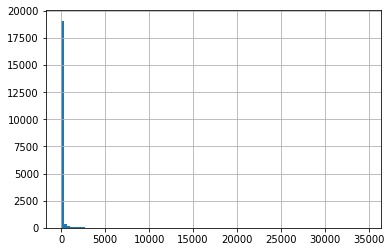

In [204]:
df.upvotes.hist(bins=100)

<AxesSubplot:>

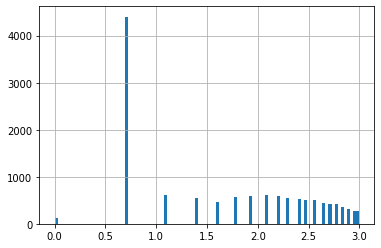

In [216]:
log_upvotes = np.log(df.upvotes+1)
log_upvotes[log_upvotes < 3].hist(bins=100)

In [217]:
df.groupby('upvotes')['upvotes'].count()

upvotes
0         124
1        4402
2         617
3         557
4         453
         ... 
14966       1
15472       1
17905       1
18806       1
34572       1
Name: upvotes, Length: 1046, dtype: int64

<AxesSubplot:>

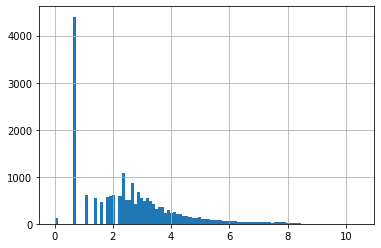

In [210]:
np.log(df.upvotes+1).hist(bins=100)

#### Build Dense layer model

In [467]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [439]:
d_model = Sequential()
d_model.add(layers.Dense(10, input_shape=(max_length,vec_size), activation='relu'))

d_model.add(layers.Dense(128, activation='relu'))
d_model.add(layers.Dense(32, activation='relu'))

# Binary output
d_model.add(layers.Dense(1, activation='sigmoid'))

In [444]:
# compile
opt = Adam(
learning_rate=0.001 #, beta_1=0.9, beta_2=0.99
)

d_model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics = 'accuracy')

In [445]:
es = EarlyStopping(patience=10, restore_best_weights=False)

history = d_model.fit(X_train, y_train,
    batch_size=8,
    epochs=1000,
    validation_split=0.3,
    shuffle=True,
    callbacks=[es])

Epoch 1/1000
1225/1225 [==============================] - 3s 2ms/step - loss: 0.6747 - accuracy: 0.5906 - val_loss: 0.6751 - val_accuracy: 0.5868
Epoch 2/1000
1225/1225 [==============================] - 2s 2ms/step - loss: 0.6739 - accuracy: 0.5926 - val_loss: 0.6751 - val_accuracy: 0.5872
Epoch 3/1000
1225/1225 [==============================] - 2s 2ms/step - loss: 0.6735 - accuracy: 0.5926 - val_loss: 0.6751 - val_accuracy: 0.5876
Epoch 4/1000
1225/1225 [==============================] - 2s 2ms/step - loss: 0.6736 - accuracy: 0.5918 - val_loss: 0.6748 - val_accuracy: 0.5870
Epoch 5/1000
1225/1225 [==============================] - 2s 2ms/step - loss: 0.6733 - accuracy: 0.5937 - val_loss: 0.6753 - val_accuracy: 0.5857
Epoch 6/1000
1225/1225 [==============================] - 3s 2ms/step - loss: 0.6732 - accuracy: 0.5931 - val_loss: 0.6759 - val_accuracy: 0.5878
Epoch 7/1000
1225/1225 [==============================] - 3s 2ms/step - loss: 0.6732 - accuracy: 0.5934 - val_loss: 0.6748 -

KeyboardInterrupt: 

#### Build RNN LSTM Model

In [318]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
import tensorflow as tf

from tensorflow.keras.metrics import Recall, Precision, Accuracy, BinaryAccuracy

from tensorflow.keras import regularizers, Sequential, layers

from tensorflow.keras.callbacks import EarlyStopping

In [336]:
l_model = Sequential()
l_model.add(layers.Masking(mask_value=-1000))

# initializer = tf.keras.initializers.LecunUniform() #  TruncatedNormal()  ,kernel_initializer=initializer
# kernel_regularizer='l1')
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

l_model.add(layers.LSTM(32, activation = "tanh",kernel_regularizer='l1'))
l_model.add(layers.Dense(20, activation = "relu"))
l_model.add(layers.Dense(1, activation="sigmoid"))

In [308]:
Accuracy()

In [337]:
metrics = [
#     Recall(),
    Precision(thresholds=0.38),
    BinaryAccuracy(threshold=0.38)
#     keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
#     keras.metrics.BinaryAccuracy(threshold=0.38)
]

In [338]:
# compile

# lr_schedule = ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = Adam(learning_rate=0.01)

l_model.compile(loss='binary_crossentropy',
              optimizer= 'rmsprop', # customize learning rate
              metrics= metrics)

In [311]:
accuracy

0.57345

In [312]:
y_train.value_counts()

1    7680
0    6320
Name: cat_upvotes, dtype: int64

In [339]:
es = EarlyStopping(patience=10, restore_best_weights=True)

l_history = l_model.fit(X_train, y_train,
    batch_size=16,
    epochs=500,
    validation_split=0.3,
    shuffle=True,
    callbacks=[es])

Epoch 1/500
613/613 [==============================] - 12s 11ms/step - loss: 0.8679 - precision_16: 0.2544 - binary_accuracy: 0.7015 - val_loss: 0.5918 - val_precision_16: 0.4483 - val_binary_accuracy: 0.7331
Epoch 2/500
613/613 [==============================] - 5s 8ms/step - loss: 0.5775 - precision_16: 0.4414 - binary_accuracy: 0.7435 - val_loss: 0.5946 - val_precision_16: 0.4078 - val_binary_accuracy: 0.7229
Epoch 3/500
613/613 [==============================] - 5s 9ms/step - loss: 0.5756 - precision_16: 0.4515 - binary_accuracy: 0.7430 - val_loss: 0.5894 - val_precision_16: 0.3962 - val_binary_accuracy: 0.7198
Epoch 4/500
613/613 [==============================] - 5s 9ms/step - loss: 0.5746 - precision_16: 0.4257 - binary_accuracy: 0.7398 - val_loss: 0.5902 - val_precision_16: 0.4455 - val_binary_accuracy: 0.7324
Epoch 5/500
613/613 [==============================] - 5s 9ms/step - loss: 0.5737 - precision_16: 0.4549 - binary_accuracy: 0.7428 - val_loss: 0.5905 - val_precision_16: 

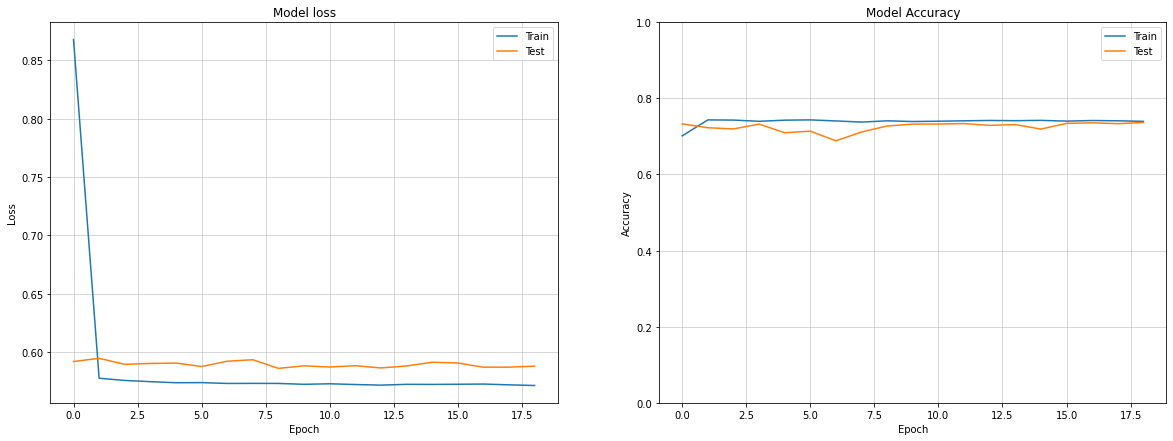

In [340]:
plot_loss_accuracy(l_history)

In [341]:
y_predict = l_model.predict(X_test)

In [260]:
y_predict.shape

(6000, 1)

In [280]:
y_predict[y_predict<0.5]

array([0.18666893, 0.07337698, 0.12081945, ..., 0.19522563, 0.08940387,
       0.05261356], dtype=float32)

In [342]:
l_model.evaluate(X_test,y_test)

188/188 [==============================] - 1s 3ms/step - loss: 0.5694 - precision_16: 0.4242 - binary_accuracy: 0.7395


[0.5694441199302673, 0.42424243688583374, 0.7394999861717224]

# 1. 0.6024 batchsize 32

In [ ]:
# 0.6033 LecunUniform()

In [ ]:
# 0.6038 TruncatedNormal()
# 0.6043 initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

In [ ]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
import tensorflow as tf
l_model = Sequential()
l_model.add(layers.Masking())
initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
l_model.add(layers.LSTM(32, activation = "tanh",kernel_initializer=initializer, kernel_regularizer='l2'))
l_model.add(layers.Dense(20, activation = "relu"))
l_model.add(layers.Dense(1, activation="sigmoid"))
# compile
l_model.compile(loss='binary_crossentropy',
              optimizer= 'rmsprop',
              metrics=['accuracy'])

es = EarlyStopping(patience=10, restore_best_weights=True)

l_history = l_model.fit(X_train, y_train,
    batch_size=8,
    epochs=1000,
    validation_split=0.3,
    shuffle=True,
    callbacks=[es])

In [162]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
#     ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['binary_accuracy'])
    ax[1].plot(history.history['val_binary_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

In [358]:
vec_size = 40
model = Word2Vec(sentences=data['lemmatize'], vector_size=vec_size, min_count=10, window=4)
model.save("../models/w2v_150k")

In [359]:
test_model = Word2Vec.load("../models/w2v_150k")

In [360]:
test_model.wv.most_similar('dog', topn=15)

[('animal', 0.6996986865997314),
 ('pup', 0.6816320419311523),
 ('kid', 0.6189768314361572),
 ('theyre', 0.6126769185066223),
 ('mine', 0.611507773399353),
 ('pooch', 0.6083589196205139),
 ('doggos', 0.6054732203483582),
 ('doggy', 0.604890763759613),
 ('also', 0.5998243093490601),
 ('story', 0.5967597961425781),
 ('comment', 0.5960269570350647),
 ('people', 0.5943179130554199),
 ('cat', 0.5779100060462952),
 ('owner', 0.5767818093299866),
 ('mother', 0.5735674500465393)]

In [25]:
from upvotemodel.prenlp.preprocess_text import embedding 

[autoreload of upvotemodel.prenlp.preprocess_text failed: Traceback (most recent call last):
  File "/Users/wanghin/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/wanghin/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/wanghin/.pyenv/versions/3.8.12/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/wanghin/.pyenv/versions/3.8.12/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/wanghin/code/LeonNeubeck/Upvote_Model/upvotemodel/prenl

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
# __file__

In [3]:
os.path.dirname(os.path.abspath(''))

'/Users/wanghin/code/LeonNeubeck/Upvote_Model'

In [10]:
os.path.dirname(os.path.dirname(os.path.abspath('')))

'/Users/wanghin/code/LeonNeubeck'

In [4]:
sys.path

['/Users/wanghin/code/LeonNeubeck/Upvote_Model/notebooks',
 '/Users/wanghin/code/CitizenKylin/data-context-and-setup',
 '/Users/wanghin/code/LeonNeubeck/Upvote_Model/notebooks',
 '/Users/wanghin/.pyenv/versions/3.8.12/lib/python38.zip',
 '/Users/wanghin/.pyenv/versions/3.8.12/lib/python3.8',
 '/Users/wanghin/.pyenv/versions/3.8.12/lib/python3.8/lib-dynload',
 '',
 '/Users/wanghin/.pyenv/versions/lewagon/lib/python3.8/site-packages',
 '/Users/wanghin/.pyenv/versions/lewagon/lib/python3.8/site-packages/IPython/extensions',
 '/Users/wanghin/.ipython',
 '/Users/wanghin/code/LeonNeubeck/Upvote_Model']

In [6]:
embedding(['dog'],'../models/w2v_150k')

array([[ 0.35266894, -0.44480756,  1.2790529 ,  0.2264111 ,  0.80346364,
         0.24137893,  0.22789069,  0.90425175, -0.08094738, -1.4144479 ,
         1.246112  ,  1.0234498 ,  0.03637016,  0.73463815, -0.05412924,
        -0.17712502,  1.2520365 ,  0.5288012 , -0.55155796, -1.4010589 ,
         1.0026082 ,  0.24980044,  0.76055455,  0.04039042, -0.6380358 ,
        -1.3701535 , -0.12179693,  1.5690833 ,  0.43725434,  0.63406813,
        -0.50388044,  0.06886046,  1.2432551 ,  1.2660683 , -0.3588837 ,
        -0.8647348 ,  0.63890016, -1.0180691 ,  0.23994292,  0.1479732 ]],
      dtype=float32)

In [5]:
pwd

'/Users/wanghin/code/LeonNeubeck/Upvote_Model/notebooks'